In [1]:
# ISA 530: Final Project
# Quantifying the Predictive Power of Biological vs. Environmental Features in Health Outcomes 
# Supervised Learning 
# Carly Carroll

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Prepare Data

In [3]:
# paths to data
base_path = "/Users/carlycarroll/Desktop/MIDUS/Data"
long_path = f"{base_path}/MIDUS_twins_long.csv"

# load and display dataset
long  = pd.read_csv(long_path)
display(long.head())

# working copy
df = long.copy()

# ensure SRH is numeric
df["SRH"] = pd.to_numeric(df["SRH"], errors="coerce")

# define biological and environmental features
biological = ["BMI", "HYPERTEN", "DIABETES", "ASTHMA", "DEPRESS"]
environmental = ["EDUC", "HHINCOME", "SMOKING", "ALCOHOL", "EXERCISE", 'MARITAL']

,M2ID,wave,M2FAMNUM,SAMPLMAJ,ZYGCAT,SRH,HYPERTEN,DIABETES,ASTHMA,DEPRESS,BMI,EDUC,HHINCOME,SMOKING,ALCOHOL,EXERCISE,MARITAL,AGE,SEX
0,10005.0,M1,120803.0,3.0,3.0,9.0,1.0,2.0,2.0,2.0,26.507816,5.0,2.0,2.0,32.0,1.0,NaN,NaN,NaN
1,10006.0,M1,120772.0,3.0,2.0,8.0,2.0,2.0,2.0,1.0,26.891987,6.0,2.0,2.0,21.0,2.0,NaN,NaN,NaN
2,10010.0,M1,120378.0,3.0,3.0,6.0,2.0,2.0,2.0,1.0,23.056296,3.0,2.0,1.0,18.0,2.0,3.0,NaN,NaN
3,10015.0,M1,120805.0,3.0,1.0,7.0,2.0,2.0,2.0,1.0,31.601253,5.0,NaN,1.0,19.0,2.0,3.0,NaN,NaN
4,10030.0,M1,120243.0,3.0,1.0,8.0,2.0,2.0,2.0,2.0,25.584351,8.0,2.0,2.0,24.0,2.0,1.0,NaN,NaN


### Principal Component Analysis

##### Biological

[Biological] explained var: [0.284 0.213]
[Biological] corr(PC1,SRH)=-0.357  corr(PC2,SRH)=0.111


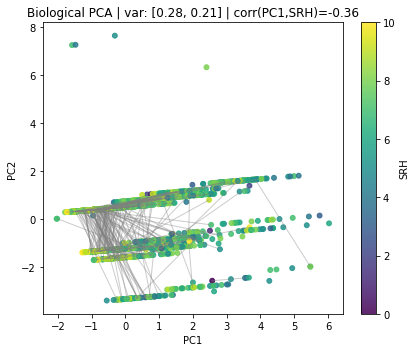


Top contributors to PC1 (Biological):


HYPERTEN   -0.568372
BMI         0.554666
DIABETES   -0.550410
ASTHMA     -0.221819
DEPRESS    -0.130937
Name: PC1, dtype: float64


Top contributors to PC2 (Biological):


DEPRESS     0.741009
ASTHMA      0.619679
DIABETES   -0.183494
HYPERTEN   -0.169590
BMI         0.066878
Name: PC2, dtype: float64

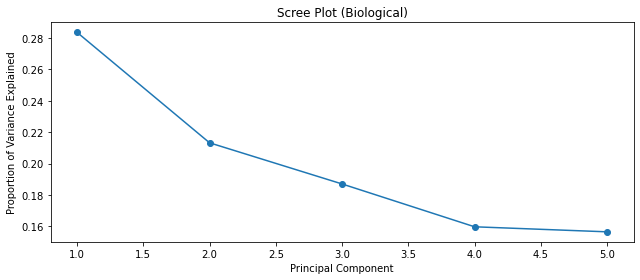

In [10]:
bio_df = df[["M2ID","M2FAMNUM","wave","SRH"] + biological].copy()
X = bio_df[biological].apply(pd.to_numeric, errors="coerce")

# impute missing values with median 
imputer = SimpleImputer(strategy="median")
X_imputer = imputer.fit_transform(X)

# standardize features 
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X_imputer)

# apply pca
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaler)

# add scores
bio_df["PC1"] = Z[:,0]
bio_df["PC2"] = Z[:,1]

# variance explained and corr with srh
evr = pca.explained_variance_ratio_
tmp = pd.DataFrame({"PC1": Z[:,0], "PC2": Z[:,1], "SRH": bio_df["SRH"]})
c1 = tmp[["PC1","SRH"]].dropna().corr().iloc[0,1]
c2 = tmp[["PC2","SRH"]].dropna().corr().iloc[0,1]
print("[Biological] explained var:", np.round(evr, 3))
print("[Biological] corr(PC1,SRH)={:.3f}  corr(PC2,SRH)={:.3f}".format(c1, c2))

# plot pc1 vs pc2 colored by srh and connect twins
plt.figure(figsize=(6,5))
scatter = plt.scatter(bio_df["PC1"], bio_df["PC2"], c=bio_df["SRH"], cmap="viridis", s=24, alpha=0.85)
plt.colorbar(scatter, label="SRH")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"Biological PCA | var: [{evr[0]:.2f}, {evr[1]:.2f}] | corr(PC1,SRH)={c1:.2f}")
for fam, g in bio_df.groupby("M2FAMNUM"):
    if len(g) == 2:
        plt.plot(g["PC1"].values, g["PC2"].values, color="gray", linewidth=1.0, alpha=0.4)
plt.tight_layout(); plt.show()

# get PCA loadings 
loadings_bio = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=["PC1", "PC2"]
)
print("\nTop contributors to PC1 (Biological):")
display(loadings_bio.loc["PC1"].sort_values(key=abs, ascending=False).head(10))
print("\nTop contributors to PC2 (Biological):")
display(loadings_bio.loc["PC2"].sort_values(key=abs, ascending=False).head(10))

# refit PCA with all components for a full elbow plot
pca_full = PCA()
pca_full.fit(X_scaler)
evr_full = pca_full.explained_variance_ratio_
plt.figure(figsize=(9,4))
plt.plot(range(1, len(evr_full)+1), evr_full, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot (Biological)")
plt.tight_layout()
plt.show()

##### Environmental

[Environmental] explained var: [0.202 0.175]
[Environmental] corr(PC1,SRH)=0.049  corr(PC2,SRH)=0.068


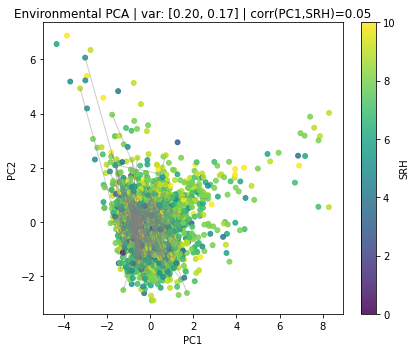


Top contributors to PC1 (Environmental):


HYPERTEN   -0.568372
BMI         0.554666
DIABETES   -0.550410
ASTHMA     -0.221819
DEPRESS    -0.130937
Name: PC1, dtype: float64


Top contributors to PC2 (Environmental):


DEPRESS     0.741009
ASTHMA      0.619679
DIABETES   -0.183494
HYPERTEN   -0.169590
BMI         0.066878
Name: PC2, dtype: float64

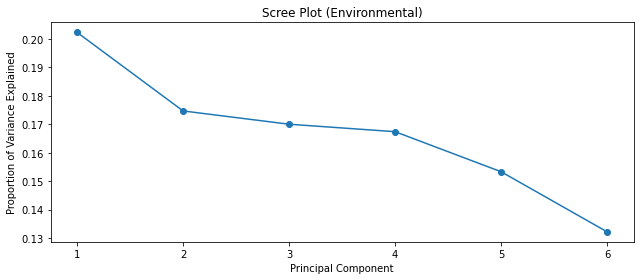

In [15]:
env_df = df[["M2ID","M2FAMNUM","wave","SRH"] + environmental].copy()
X = env_df[environmental].apply(pd.to_numeric, errors="coerce")

# impute missing values with median 
imputer = SimpleImputer(strategy="median")
X_imputer = imputer.fit_transform(X)

# standardize features
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X_imputer)

# apply pca
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaler)

# add scores
env_df["PC1"] = Z[:,0]
env_df["PC2"] = Z[:,1]

# variance explained and corr with srh
evr = pca.explained_variance_ratio_
tmp = pd.DataFrame({"PC1": Z[:,0], "PC2": Z[:,1], "SRH": env_df["SRH"]})
c1 = tmp[["PC1","SRH"]].dropna().corr().iloc[0,1]
c2 = tmp[["PC2","SRH"]].dropna().corr().iloc[0,1]
print("[Environmental] explained var:", np.round(evr, 3))
print("[Environmental] corr(PC1,SRH)={:.3f}  corr(PC2,SRH)={:.3f}".format(c1, c2))

# plot pc1 vs pc2 colored by srh and connect twins
plt.figure(figsize=(6,5))
scatter = plt.scatter(env_df["PC1"], env_df["PC2"], c=env_df["SRH"], cmap="viridis", s=24, alpha=0.85)
plt.colorbar(scatter, label="SRH")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"Environmental PCA | var: [{evr[0]:.2f}, {evr[1]:.2f}] | corr(PC1,SRH)={c1:.2f}")
for fam, g in env_df.groupby("M2FAMNUM"):
    if len(g) == 2:
        plt.plot(g["PC1"].values, g["PC2"].values, color="gray", linewidth=1.0, alpha=0.4)
plt.tight_layout(); plt.show()

# get PCA loadings 
loadings_env = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=["PC1", "PC2"]
)
print("\nTop contributors to PC1 (Environmental):")
display(loadings_bio.loc["PC1"].sort_values(key=abs, ascending=False).head(10))
print("\nTop contributors to PC2 (Environmental):")
display(loadings_bio.loc["PC2"].sort_values(key=abs, ascending=False).head(10))

# refit PCA with all components for a full scree plot
pca_full_env = PCA()
pca_full_env.fit(X_scaler)

evr_full_env = pca_full_env.explained_variance_ratio_

plt.figure(figsize=(9,4))
plt.plot(range(1, len(evr_full_env)+1), evr_full_env, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot (Environmental)")
plt.tight_layout()
plt.show()

### K-Means Clustering

##### Biological

[BIO] twin same-cluster (overall): 0.54
[BIO] twin same-cluster by wave:
 wave
M1    0.561
M2    0.540
M3    0.484
dtype: float64
[BIO] silhouette: 0.5898779578314273
[BIO] cluster counts:
 0    1696
1     574
2     756
Name: cluster, dtype: int64 



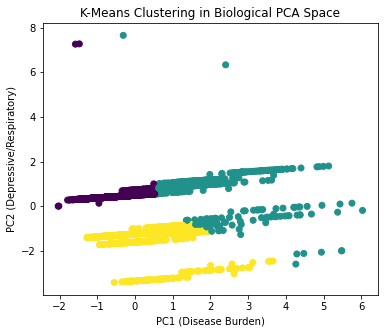

In [19]:
d = bio_df.dropna(subset=["PC1","PC2"]).copy()
Xp = d[["PC1","PC2"]].values

# apply k-means
km = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = km.fit_predict(Xp)
d["cluster"] = labels

# twin same-cluster 
same_overall = (
    d.groupby(["M2FAMNUM","wave"])
     .apply(lambda g: int(len(g)==2 and g["cluster"].nunique()==1))
     .mean()
)

# by wave 
same_by_wave = (
    d.groupby("wave")
     .apply(lambda s: s.groupby(["M2FAMNUM","wave"])
                      .apply(lambda g: int(len(g)==2 and g["cluster"].nunique()==1)).mean())
     .round(3)
)

# compute silhouette score
sil = np.nan
vc = pd.Series(labels).value_counts()
if len(vc) > 1 and vc.min() > 1:
    sil = silhouette_score(Xp, labels)

# print results
print("[BIO] twin same-cluster (overall):", round(same_overall,3))
print("[BIO] twin same-cluster by wave:\n", same_by_wave)
print("[BIO] silhouette:", sil if not np.isnan(sil) else "nan")
print("[BIO] cluster counts:\n", d["cluster"].value_counts().sort_index(), "\n")

# biological clustering
kmeans_bio = KMeans(n_clusters=3, random_state=42).fit(bio_df[['PC1','PC2']])
bio_df['cluster'] = kmeans_bio.labels_

plt.figure(figsize=(6,5))
plt.scatter(bio_df['PC1'], bio_df['PC2'], c=bio_df['cluster'], cmap='viridis')
plt.title("K-Means Clustering in Biological PCA Space")
plt.xlabel("PC1 (Disease Burden)")
plt.ylabel("PC2 (Depressive/Respiratory)")
plt.show()

##### Environmental

[ENV] twin same-cluster (overall): 0.586
[ENV] twin same-cluster by wave:
 wave
M1    0.606
M2    0.554
M3    0.589
dtype: float64
[ENV] silhouette: 0.41163845261099496
[ENV] cluster counts:
 0     524
1     864
2    1638
Name: cluster, dtype: int64 



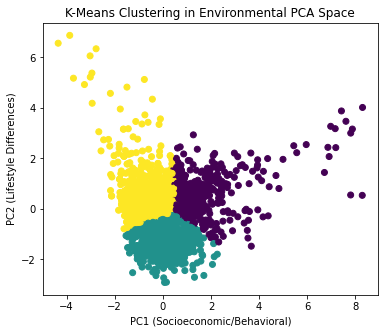

In [17]:
d = env_df.dropna(subset=["PC1","PC2"]).copy()
Xp = d[["PC1","PC2"]].values

# apply k-means
km = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = km.fit_predict(Xp)
d["cluster"] = labels

# twin same-cluster 
same_overall = (
    d.groupby(["M2FAMNUM","wave"])
     .apply(lambda g: int(len(g)==2 and g["cluster"].nunique()==1))
     .mean()
)

# by wave 
same_by_wave = (
    d.groupby("wave")
     .apply(lambda s: s.groupby(["M2FAMNUM","wave"])
                      .apply(lambda g: int(len(g)==2 and g["cluster"].nunique()==1)).mean())
     .round(3)
)

# compute silhouette score
sil = np.nan
vc = pd.Series(labels).value_counts()
if len(vc) > 1 and vc.min() > 1:
    sil = silhouette_score(Xp, labels)

# print results
print("[ENV] twin same-cluster (overall):", round(same_overall,3))
print("[ENV] twin same-cluster by wave:\n", same_by_wave)
print("[ENV] silhouette:", sil if not np.isnan(sil) else "nan")
print("[ENV] cluster counts:\n", d["cluster"].value_counts().sort_index(), "\n")

# environmental clustering
kmeans_env = KMeans(n_clusters=3, random_state=42).fit(env_df[['PC1','PC2']])
env_df['cluster'] = kmeans_env.labels_

plt.figure(figsize=(6,5))
plt.scatter(env_df['PC1'], env_df['PC2'], c=env_df['cluster'], cmap='viridis')
plt.title("K-Means Clustering in Environmental PCA Space")
plt.xlabel("PC1 (Socioeconomic/Behavioral)")
plt.ylabel("PC2 (Lifestyle Differences)")
plt.show()